Submission with stacking with logistic regression, knn, xgboost and random forest

In [1]:
import json
import pandas as pd
import os
import numpy as np

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')

In [2]:
train_data = []

print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            train_data.append(json.loads(line))
        print(f"Successfully loaded {len(train_data)} battles.")
        
    # Let's inspect the first battle to see its structure
    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]
        
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', []) [:2] # Show first 2 turns
        
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 2:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",

In [3]:
test_data = []

print(f"Loading data from '{test_file_path}'...")
try:
    with open(test_file_path, 'r') as f:
        for line in f:
            test_data.append(json.loads(line))
    
    print("\n--- Structure of the first test battle: ---")
    if test_data:
            first_test_battle = test_data[0]
            
            test_battle_for_display = first_test_battle.copy()
            test_battle_for_display['battle_timeline'] = test_battle_for_display.get('battle_timeline', [])[:2] # Show first 2 turns
            
            print(json.dumps(test_battle_for_display, indent=4))
            if len(first_test_battle.get('battle_timeline', [])) > 3:
                print("    ...")
                print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{test_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/test.jsonl'...

--- Structure of the first test battle: ---
{
    "p1_team_details": [
        {
            "name": "gengar",
            "level": 100,
            "types": [
                "ghost",
                "poison"
            ],
            "base_hp": 60,
            "base_atk": 65,
            "base_def": 60,
            "base_spa": 130,
            "base_spd": 130,
            "base_spe": 110
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",
                "notype"
            ],
            "base_hp": 250,
            "base_atk": 5,
            "base_def": 5,
            "base_spa": 105,
            "base_spd": 105,
            "base_spe": 50
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 

In [4]:
count_level = 0
for battle in train_data:
    squad = battle.get("p1_team_details")
    for pokemon in squad:
        level = pokemon.get("level")
        if level != 100:
            count_level += 1
print(count_level)

13


In [5]:
used_pokemon = set()
count = 0
for battle in train_data:
    battle_timeline = battle.get('battle_timeline', [])
    for i in battle_timeline:
        nome_p1 = i.get("p1_pokemon_state").get("name")
        nome_p2 = i.get("p2_pokemon_state").get("name")
        if nome_p1 not in used_pokemon:
            used_pokemon.add(nome_p1)
            count += 1
        if nome_p2 not in used_pokemon:
            used_pokemon.add(nome_p2)
            count += 1
print(count)

20


In [6]:
pokedex = {}

for battle in train_data:
    squad = battle.get("p1_team_details")
    for pokemon in squad:
        nome = pokemon.get("name")
        if nome not in pokedex:
            pokedex[nome] = pokemon
    pokemon_p2 = battle.get("p2_lead_details").get("name")
    if pokemon_p2 not in pokedex:
        pokedex[pokemon_p2] = battle.get("p2_lead_details")

print(len(pokedex))
#print(json.dumps(pokedex, indent=4))

20


# **Feature engineering** 
We create a function **create_simple_features** that takes as input a list of dictionaries (jsonl files) and returns a dataframe containing all the features we created.

In [7]:
from tqdm.notebook import tqdm
import numpy as np

def create_simple_features(data: list[dict]) -> pd.DataFrame:
    """
    A very basic feature extraction function.
    It only uses the aggregated base stats of the player's team and opponent's lead.
    """
    feature_list = []
    for battle in tqdm(data, desc="Extracting features"):
        features = {}
        
        # --- Player 1 Team Features ---
        p1_team = battle.get('p1_team_details', [])
        if p1_team:
            features['p1_mean_hp'] = np.mean([p.get('base_hp', 0) for p in p1_team])
            features['p1_mean_spe'] = np.mean([p.get('base_spe', 0) for p in p1_team])
            features['p1_mean_atk'] = np.mean([p.get('base_atk', 0) for p in p1_team])
            features['p1_mean_def'] = np.mean([p.get('base_def', 0) for p in p1_team])
            features['p1_mean_spa'] = np.mean([p.get('base_spa', 0) for p in p1_team])
            features['p1_mean_spd'] = np.mean([p.get('base_spd', 0) for p in p1_team])
            
        # --- Player 2 Team Features ---
        
        battle_timeline = battle.get('battle_timeline', [])
        p2_team = {}
        for i in battle_timeline:
            name_p2 = i.get("p2_pokemon_state", {}).get("name")
            if name_p2:
                p2_team[name_p2] = pokedex.get(name_p2, {})
        features['p2_mean_hp'] = np.mean([p2_team[p].get('base_hp', 0) for p in p2_team])
        features['p2_mean_spe'] = np.mean([p2_team[p].get('base_spe', 0) for p in p2_team])
        features['p2_mean_atk'] = np.mean([p2_team[p].get('base_atk', 0) for p in p2_team])
        features['p2_mean_def'] = np.mean([p2_team[p].get('base_def', 0) for p in p2_team])
        features['p2_mean_spa'] = np.mean([p2_team[p].get('base_spa', 0) for p in p2_team])
        features['p2_mean_spd'] = np.mean([p2_team[p].get('base_spd', 0) for p in p2_team])

        # --- Players Status pokemon ---
        
        #if battle_timeline:
        status_p1=0
        status_p2=0
        for i in battle_timeline:
            if i.get('p1_pokemon_state').get("status")!= 'nostatus':
                status_p1+=1
            if i.get('p2_pokemon_state').get("status")!= 'nostatus':
                status_p2+=1
        status_p1= status_p1/len(battle_timeline)
        features['p1_status'] =  round(status_p1,3)
        status_p2= status_p2/len(battle_timeline)
        features['p2_status'] =  round(status_p2,3)
        features["diff_status"] = features['p1_status'] - features['p2_status']

                # --- Players Boosts ---
                
        boosts_p1 = 0
        boosts_p2 = 0
        
        for i in battle_timeline:
            boosts1 = i.get('p1_pokemon_state').get("boosts")
            boosts2 = i.get('p2_pokemon_state').get("boosts")
        
            for j in boosts1:
                boosts_p1 += boosts1.get(j)
            for k in boosts2:
                boosts_p2 += boosts2.get(k)
        
        
        features["boosts_p1"] = boosts_p1
        features["boosts_p2"] = boosts_p2
        features["diff_boost"] = boosts_p1 - boosts_p2
        
                # --- Players' move "null" ---
        null_1=0
        null_2=0
        for i in battle_timeline:
            if not i.get('p1_move_details'):
                null_1 += 1
            if not i.get('p2_move_details'):
                null_2 += 1
        
        features['null_p1'] = null_1
        features['null_p2'] = null_2

                # --- Players' accuracy ---
        acc_1 = 0
        n_acc1 = 0
        acc_2 = 0
        n_acc2 = 0
        for i in battle_timeline:
            if i.get('p1_move_details'):
                acc_1 += float(i.get('p1_move_details').get('accuracy'))
                n_acc1 += 1
            if i.get('p2_move_details'):
                acc_2 += float(i.get('p2_move_details').get('accuracy'))
                n_acc2 += 1
        if n_acc1 != 0:
            features['avg_acc_p1'] = acc_1/n_acc1
        else:
            features['avg_acc_p1'] = 0
        if n_acc2 != 0:
            features['avg_acc_p2'] = acc_2/n_acc2
        else:
            features['avg_acc_p2'] = 0
                
        features["diff_avg_acc"] = features['avg_acc_p1'] - features['avg_acc_p2']

        
        # --- numers of time in which each player attacks ---

        diz_p1 = {}
        count_p2 = 0
        for i in battle_timeline:
            nome = i.get('p1_pokemon_state').get('name')
            hp = i.get('p1_pokemon_state').get('hp_pct')
            if nome not in diz_p1:
                if int(hp) != 1:
                    diz_p1[nome] = hp
                    count_p2 += 1
                else:
                    diz_p1[nome] = hp
            else:
                if diz_p1[nome] > hp:
                    diz_p1[nome] = hp
                    count_p2 += 1
                else:
                    diz_p1[nome] = hp
        diz_p2 = {}
        count_p1 = 0
        for i in battle_timeline:
            nome = i.get('p2_pokemon_state').get('name')
            hp = i.get('p2_pokemon_state').get('hp_pct')
            if nome not in diz_p2:
                if int(hp) != 1:
                    diz_p2[nome] = hp
                    count_p1 += 1
                else:
                    diz_p2[nome] = hp
            else:
                if diz_p2[nome] > hp:
                    diz_p2[nome] = hp
                    count_p1 += 1
                else:
                    diz_p2[nome] = hp

        features['n_atk_p1'] = count_p1
        features['n_atk_p2'] = count_p2

        
        # --- Difference of damage inflicted ---

        diz_1 = {}
        def_p1 = 0
        diz_2 = {}
        atk_p1 = 0
        for i in battle_timeline:
            # somma difesa p1
            diff_p1 = 0
            nome_1 = i.get("p1_pokemon_state").get("name")
            hp_1 = i.get("p1_pokemon_state").get("hp_pct")
            if nome_1 not in diz_1:
                if int(hp_1) != 1:
                    diff_p1 = 1 - hp_1
                    diz_1[nome_1] = hp_1
                else:
                    diz_1[nome_1] = hp_1
            else:
                diff_p1 = diz_1[nome_1] - hp_1
                diz_1[nome_1] = hp_1
            def_p1 += diff_p1 
            
        for i in battle_timeline:
            # somma attacco p1 (o difesa p2)
            diff_p2 = 0
            nome_2 = i.get("p2_pokemon_state").get("name")
            hp_2 = i.get("p2_pokemon_state").get("hp_pct")   
            if nome_2 not in diz_2:
                if int(hp_2) != 1:
                    diff_p2 = 1 - hp_2
                    diz_2[nome_2] = hp_2
                else:
                    diz_2[nome_2] = hp_2
            else:
                diff_p2 = diz_2[nome_2] - hp_2
                diz_2[nome_2] = hp_2
            atk_p1 += diff_p2
        
        features["diff_damage"] = atk_p1 - def_p1
        
        # --- Count priority ---
        
        priority_1 = 0
        for i in battle_timeline:
            if i.get('p1_move_details'):
                priority = i.get('p1_move_details').get('priority')
                priority_1 += priority

        priority_2 = 0
        for i in battle_timeline:
            if i.get('p2_move_details'):
                priority = i.get('p2_move_details').get('priority')
                priority_2 += priority
        features["priority_1"] = priority_1
        features["priority_2"] = priority_2
        features["diff_priority"] = priority_1 - priority_2

                

        # --- Players' KO ---

        count_p1 = 0
        count_p2 = 0
        for i in battle_timeline:
            if i.get('p1_pokemon_state').get('status') == 'fnt':
                count_p1 += 1
            if i.get('p2_pokemon_state').get('status') == 'fnt':
                count_p2 += 1
        features['ko_p1'] = count_p1
        features['ko_p2'] = count_p2
        features["diff_ko"] = count_p1 - count_p2


        # --- Number of special attacks ---
        
        count_p1 = 0
        sp_atk_1 = 0
        count_p2 = 0
        sp_def_1 = 0
        for i in battle_timeline:
            if i.get("p1_move_details"):
                nome_p1 = i.get("p1_pokemon_state").get("name")
                if i.get('p1_move_details').get('category') == 'SPECIAL':
                    count_p1 += 1
                    sp_atk_1 += next(p.get('base_spa', 0) for p in p1_team if p.get("name") == nome_p1)
            if i.get("p2_move_details"):
                if i.get('p2_move_details').get('category') == 'SPECIAL':
                    count_p2 += 1
        features['n_sp_atk_1'] = count_p1
        features['n_sp_atk_2'] = count_p2
        features["diff_sp_atk"] = count_p1 - count_p2
        if count_p1 != 0:
            features["avg_sp_atk_1"] = sp_atk_1 / count_p1
        else:
            features["avg_sp_atk_1"] = 0
        #features["sp_atk_1"] = sp_atk_1
        
        # --- Numbers of time in which each player uses Ice Beam or Blizzard ---
        count_move_p1_frz = 0
        count_move_p2_frz = 0

        for i in battle_timeline:
            if i.get("p1_move_details"):
                move = i.get("p1_move_details").get("name")
                if move == "blizzard" or move == "icebeam":
                    count_move_p1_frz += 1
            
            if i.get("p2_move_details"):
                move = i.get("p2_move_details").get("name")
                if move == "blizzard" or move == "icebeam":
                    count_move_p2_frz += 1

      
        # --- Numbers of time in which each player uses Ice Beam or Blizzard ---

        count_move_p1_spe = 0
        count_move_p2_spe = 0

        for i in battle_timeline:
            if i.get("p1_move_details"):
                move = i.get("p1_move_details").get("name")
                if move == "thunderwave":
                    count_move_p1_spe += 1
            
            if i.get("p2_move_details"):
                move = i.get("p2_move_details").get("name")
                if move == "thunderwave":
                    count_move_p2_spe += 1

        features["move_p1_blic"] = count_move_p1_frz
        features["move_p2_blic"] = count_move_p2_frz
        features["move_p1_tw"] = count_move_p1_spe
        features["move_p2_tw"] = count_move_p1_spe

        # --- effects count ---
        
        effects_p1=0
        effects_p2=0
        for i in battle_timeline:
            if i.get('p1_pokemon_state').get("effects")[0]!= 'noeffect':
                effects_p1+=1
            if i.get('p2_pokemon_state').get("effects")[0]!= 'noeffect':
                effects_p2+=1
        effects_p1= effects_p1/len(battle_timeline)
        features['p1_effects'] =  round(effects_p1,3)
        effects_p2= effects_p2/len(battle_timeline)
        features['p2_effects'] =  round(effects_p2,3)
        features["diff_effetcs"] = features['p1_effects'] - features['p2_effects']


        # --- some interations ---
        features["p2_status x null_p2"] = features["p2_status"]*null_2
        
        features["p1_status x null_p1"] = features["p1_status"]*null_1
        

            
        # IDs and the target variable 
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])
            
        feature_list.append(features)
        
    return pd.DataFrame(feature_list).fillna(0)

We call the function twice, first giving as input the train data and then the test data such that we obtain the two dataframe for training and test. Then we create the final datasets for training (removing ID's & target features) and for the test.

In [8]:
# Features' dataframe for training set

train_df = create_simple_features(train_data)

# Features' dataframe for training set

test_df = create_simple_features(test_data)

display(train_df.head(5))
display(train_df.tail(5))

train_df.describe()

Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]

Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]

,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,move_p2_blic,move_p1_tw,move_p2_tw,p1_effects,p2_effects,diff_effetcs,p2_status x null_p2,p1_status x null_p1,battle_id,player_won
0,115.833333,80.000000,72.500000,63.333333,100.000000,100.000000,141.250000,62.5,71.25,60.000000,...,2,1,1,0.067,0.000,0.067,7.938,0.699,0,1
1,123.333333,61.666667,72.500000,65.833333,90.000000,90.000000,115.833333,80.0,72.50,63.333333,...,0,1,1,0.000,0.000,0.000,1.169,2.569,1,1
2,124.166667,65.833333,84.166667,71.666667,90.000000,90.000000,110.000000,97.5,55.00,51.250000,...,0,1,1,0.300,0.400,-0.100,3.736,1.500,2,1
3,121.666667,75.833333,77.500000,65.833333,103.333333,103.333333,101.250000,77.5,101.25,77.500000,...,0,0,0,0.000,0.133,-0.133,0.835,4.669,3,1
4,114.166667,72.500000,75.833333,79.166667,97.500000,97.500000,128.000000,72.0,77.00,67.000000,...,8,3,3,0.000,0.067,-0.067,2.932,1.200,4,1


,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,move_p2_blic,move_p1_tw,move_p2_tw,p1_effects,p2_effects,diff_effetcs,p2_status x null_p2,p1_status x null_p1,battle_id,player_won
9995,124.166667,66.666667,85.833333,75.833333,85.000000,85.000000,121.666667,76.666667,79.166667,70.000000,...,7,0,0,0.300,0.167,0.133,1.000,5.400,9995,0
9996,115.000000,65.833333,74.166667,75.000000,102.500000,102.500000,97.500000,75.000000,100.000000,89.166667,...,0,5,5,0.033,0.000,0.033,2.802,1.732,9996,0
9997,111.666667,79.166667,78.333333,72.500000,100.833333,100.833333,126.000000,64.000000,81.000000,80.000000,...,1,1,1,0.333,0.000,0.333,1.500,3.798,9997,0
9998,124.166667,66.666667,85.833333,75.833333,85.000000,85.000000,114.000000,86.000000,73.000000,71.000000,...,4,0,0,0.200,0.000,0.200,0.165,3.665,9998,0
9999,85.833333,93.333333,80.833333,66.666667,91.666667,91.666667,90.000000,82.000000,81.000000,65.000000,...,0,1,1,0.000,0.000,0.000,1.998,2.165,9999,0


,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,move_p2_blic,move_p1_tw,move_p2_tw,p1_effects,p2_effects,diff_effetcs,p2_status x null_p2,p1_status x null_p1,battle_id,player_won
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,113.124317,75.772917,77.711017,70.703667,95.409750,95.409750,115.342813,74.341042,76.207305,68.806440,...,3.069700,2.287900,2.287900,0.076504,0.074276,0.002228,2.504236,2.855163,4999.50000,0.500000
std,13.405444,8.116724,7.118607,9.887678,7.121009,7.121009,18.785770,10.322285,9.544791,12.113323,...,3.260783,2.064907,2.064907,0.139265,0.139408,0.186832,1.892661,2.027865,2886.89568,0.500025
min,63.333333,46.666667,55.833333,48.333333,73.333333,73.333333,55.000000,30.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.967000,0.000000,0.000000,0.00000,0.000000
25%,109.166667,69.166667,72.500000,63.333333,90.833333,90.833333,105.000000,67.500000,70.833333,61.250000,...,0.000000,1.000000,1.000000,0.000000,0.000000,-0.033000,1.165000,1.468000,2499.75000,0.000000
50%,116.666667,75.833333,75.833333,69.166667,96.666667,96.666667,120.000000,74.000000,75.000000,67.000000,...,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2.100000,2.400000,4999.50000,0.500000
75%,121.666667,80.000000,81.666667,75.833333,100.000000,100.000000,127.500000,80.000000,82.500000,75.833333,...,5.000000,3.000000,3.000000,0.100000,0.100000,0.034000,3.335000,3.731000,7499.25000,1.000000
max,135.833333,110.833333,110.666667,112.500000,121.666667,121.666667,250.000000,130.000000,134.000000,132.500000,...,20.000000,17.000000,17.000000,1.000000,1.000000,0.967000,20.010000,20.000000,9999.00000,1.000000


In [9]:
# Defining our features (X) and target (y)

features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]

X_train = train_df[features]
y_train = train_df['player_won']

X_test = test_df[features]

In [10]:
# creo diversi dataset da dare ai vari modelli quando faccio scaling


features_lr = [feature for feature in features if feature not in ["avg_sp_atk_1", "diff_ko", 
                                                                 
                                                                 "avg_acc_p1", "avg_acc_p2","diff_sp_atk", "diff_status"
                                                                  ]]



features_knn = [feature for feature in features if feature not in ["avg_sp_atk_1", "diff_ko", 
                                                                 "diff_priority", "boosts_p1", "boosts_p2",
                                                                 "avg_acc_p1", "avg_acc_p2","diff_sp_atk", "diff_status",
                                                                  "p1_effects", "p2_effects","diff_effetcs",
                                                                  "null_p1","ko_p2","move_p1_blic" , "move_p2_tw", 
                                                                  "p1_mean_spd", "move_p2_blic","priority_2", 
                                                                  "diff_boost","p2_status x null_p2", "p2_mean_spa", 
                                                                  "p1_mean_def","p1_mean_spa", "ko_p1", 
                                                                  "p2_mean_spd", "p2_mean_def","p1_mean_atk",
                                                                  "n_sp_atk_1", "n_sp_atk_2","move_p1_tw" ]]


features_rf = [feature for feature in features if feature not in ["avg_sp_atk_1", "diff_ko", 
                                                                 "diff_priority", "boosts_p1", "boosts_p2",
                                                                 "avg_acc_p1", "avg_acc_p2","diff_sp_atk", "diff_status",
                                                                  "p1_effects", "p2_effects","diff_effetcs",]]



features_xgb = [feature for feature in features if feature not in ["avg_sp_atk_1", "diff_ko", 
                                                                 "diff_priority", "boosts_p1", "boosts_p2",
                                                                 "avg_acc_p1", "avg_acc_p2","diff_sp_atk", "diff_status",
                                                                  "p1_effects", "p2_effects","diff_effetcs",]]

print(len(features_lr), len(features_knn), len(features_xgb), len(features_rf))

39 14 33 33


**Scaling**  
Due to the fact that having features on different scales can create problems and confusion in some models (e.g. knn) we rescale all the variable to mean = 0 and standard deviation = 1.

In [11]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


X_test_scaled_df = pd.DataFrame(X_test_scaled, columns= features)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns= features )
X_train_scaled_df.head()
X_train_scaled_df.describe()

,p1_mean_hp,p1_mean_spe,p1_mean_atk,p1_mean_def,p1_mean_spa,p1_mean_spd,p2_mean_hp,p2_mean_spe,p2_mean_atk,p2_mean_def,...,avg_sp_atk_1,move_p1_blic,move_p2_blic,move_p1_tw,move_p2_tw,p1_effects,p2_effects,diff_effetcs,p2_status x null_p2,p1_status x null_p1
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,-4.170886e-16,-9.535484e-16,7.389644e-17,-1.131184e-15,-3.353762e-16,-3.353762e-16,4.554579e-16,-2.316369e-16,-5.570655e-16,-7.673862e-16,...,1.307399e-16,-1.136868e-17,-5.684342e-17,-5.542233e-17,-5.542233e-17,-5.115908e-17,-3.126388e-17,1.136868e-17,-1.818989e-16,2.728484e-16
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,-3.714422e+00,-3.586140e+00,-3.073463e+00,-2.262559e+00,-3.100336e+00,-3.100336e+00,-3.212316e+00,-4.295876e+00,-7.460704e+00,-5.267723e+00,...,-4.145765e+00,-9.456987e-01,-9.414468e-01,-1.108047e+00,-1.108047e+00,-5.493702e-01,-5.328229e-01,-5.187946e+00,-1.323196e+00,-1.408036e+00
25%,-2.952418e-01,-8.139467e-01,-7.320642e-01,-7.454431e-01,-6.426962e-01,-6.426962e-01,-5.505939e-01,-6.627780e-01,-5.630548e-01,-6.238435e-01,...,-2.290847e-01,-9.456987e-01,-9.414468e-01,-6.237397e-01,-6.237397e-01,-5.493702e-01,-5.328229e-01,-1.885650e-01,-7.076295e-01,-6.840854e-01
50%,2.642603e-01,7.443852e-03,-2.637844e-01,-1.554538e-01,1.765170e-01,1.765170e-01,2.479227e-01,-3.304101e-02,-1.264947e-01,-1.491358e-01,...,9.730532e-02,-3.231394e-01,-3.280665e-01,-1.394322e-01,-1.394322e-01,-5.493702e-01,-5.328229e-01,-1.192733e-02,-2.135915e-01,-2.244657e-01
75%,6.372618e-01,5.208129e-01,5.557053e-01,5.188198e-01,6.446389e-01,6.446389e-01,6.471811e-01,5.482547e-01,6.593135e-01,5.801252e-01,...,5.463075e-01,6.106995e-01,5.920040e-01,3.448754e-01,3.448754e-01,1.687214e-01,1.845335e-01,1.700630e-01,4.389615e-01,4.319226e-01
max,1.694099e+00,4.319744e+00,4.629740e+00,4.227324e+00,3.687431e+00,3.687431e+00,7.168400e+00,5.392386e+00,6.055196e+00,5.258404e+00,...,1.309611e+00,5.279894e+00,5.192356e+00,7.125182e+00,7.125182e+00,6.631546e+00,6.640741e+00,5.164092e+00,9.249747e+00,8.455048e+00


In [12]:
X_train_lr = train_df[features_lr]
X_test_lr = test_df[features_lr]
scaler = StandardScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.fit_transform(X_test_lr)

X_train_knn = train_df[features_knn]
X_test_knn = test_df[features_knn]
scaler = StandardScaler()
X_train_knn_scaled = scaler.fit_transform(X_train_knn)
X_test_knn_scaled = scaler.fit_transform(X_test_knn)

X_train_xgb = train_df[features_xgb]
X_test_xgb = test_df[features_xgb]
scaler = StandardScaler()
X_train_xgb_scaled = scaler.fit_transform(X_train_xgb)
X_test_xgb_scaled = scaler.fit_transform(X_test_xgb)

X_train_rf = train_df[features_rf]
X_test_rf = test_df[features_rf]
scaler = StandardScaler()
X_train_rf_scaled = scaler.fit_transform(X_train_rf)
X_test_rf_scaled = scaler.fit_transform(X_test_rf)

# **Building the model**

In [13]:
# per la regressione logistica applico grid search per trovare i migliori iperparametri

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score

model = LogisticRegression(random_state=42, max_iter=1000)
# Define the parameter grid to search
param_grid = {
    'C': [0.1, 0.5, 1, 1.5, 2],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Create the GridSearchCV object
grid_logreg = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=['roc_auc', 'accuracy'],
    n_jobs=4,        # use 4 cores in parallel
    cv=5,            # 5-fold cross-validation, more on this later
    refit='accuracy',      # retrain the best model on the full training set
    return_train_score=True
)

# Fit the GridSearchCV object on the training data for lr
grid_logreg.fit(X_train_lr_scaled, y_train)

# Read the cv_results_ property into a DataFrame
cv_results_df = pd.DataFrame(grid_logreg.cv_results_)

# Check what type of object the best_estimator_ property returns
print(type(grid_logreg.best_estimator_))

# Use the best estimator to make predictions on the test set
predictions_lr = grid_logreg.best_estimator_.predict(X_test_lr_scaled)

# Display a few predicted class labels (0 = benign, 1 = malignant)
print("Predicted labels:", predictions_lr[:10])

cv_df = pd.DataFrame(grid_logreg.cv_results_)
best_idx = grid_logreg.best_index_
mean_acc = cv_df.loc[best_idx, 'mean_test_accuracy']
print("\naccuracy",mean_acc) 
best_log_reg = grid_logreg.best_estimator_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py",

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Predicted labels: [0 1 1 1 1 1 1 1 1 1]

accuracy 0.8302999999999999


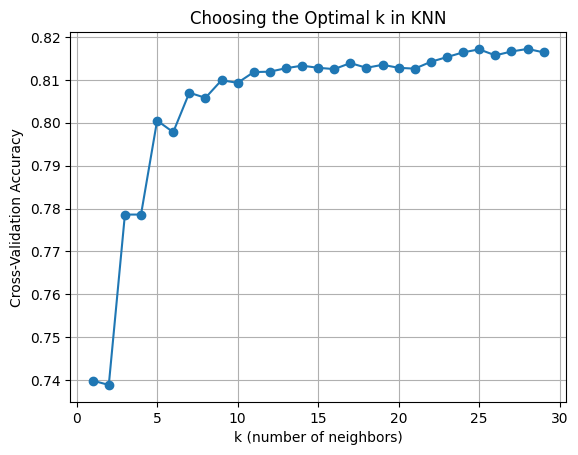

In [14]:
#faccio elbow-plot su knn per troavare miglior k
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ks = range(1, 30)
# Compute 5-fold cross-validation accuracy for each k
scores = [
    cross_val_score(KNeighborsClassifier(n_neighbors=k), X_train_knn_scaled, y_train, cv=5).mean()
    for k in ks
]
plt.plot(ks, scores, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Choosing the Optimal k in KNN')
plt.grid(True)
plt.show()

# elbow at 24

In [15]:
acc_knn = cross_val_score(KNeighborsClassifier(n_neighbors = 24), X_train_scaled, y_train, cv = 5).mean()
print(acc_knn)

0.8125


In [16]:
pip install xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [17]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
acc_xgb = cross_val_score(xgb_clf, X_train_xgb_scaled, y_train, cv =5).mean()
print(acc_xgb)

0.8263


In [18]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
acc_rf = cross_val_score(rf_clf, X_train_rf_scaled, y_train, cv = 5).mean()

print(acc_rf)

0.8300999999999998


In [19]:
# selettori di colonne

log_clf = best_log_reg
knn_clf = KNeighborsClassifier(n_neighbors = 24)


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
ct_logreg = ColumnTransformer([('sel', 'passthrough', features_lr)])
ct_knn    = ColumnTransformer([('sel', 'passthrough', features_knn)])
ct_rf     = ColumnTransformer([('sel', 'passthrough', features_rf)])
ct_xgb    = ColumnTransformer([('sel', 'passthrough', features_xgb)])


pipe_logreg = Pipeline([
    ('cols', ct_logreg),
    ('clf', log_clf)
])

pipe_knn = Pipeline([
    ('cols', ct_knn),
    ('clf', knn_clf)  # iperparametri scelti
])

pipe_rf = Pipeline([
    ('cols', ct_rf),
    ('clf', rf_clf)  # iperparametri scelti
])

pipe_xgb = Pipeline([
    ('cols', ct_xgb),
    ('clf', xgb_clf)
])

**Ensamble (Stacking)**  
Our choice for this submission is to use voting ensamble technique using as models all the ones computed previously:
- logistic regression
- knn
- xgboost
- random forest\
The idea is to use a logistic regression with inputs given by the labels predicted by the base models.

In [20]:
from sklearn.ensemble import StackingClassifier

meta_learner = LogisticRegression(random_state = 42, max_iter = 1000)
stack_tot = StackingClassifier(
    estimators=[
        ('log', pipe_logreg),
        ('knn', pipe_knn),
        ('rf', pipe_rf),
        ('xgb', pipe_xgb),
    ],
    final_estimator=meta_learner,
    stack_method='predict_proba',  # prende la colonna proba della classe positiva
    passthrough=False,              # metti True se vuoi aggiungere X originale
    cv=5                            # genera OOF per il meta-learner
)

In [21]:
param_grid = {
    'final_estimator__C': [0.1, 1, 1.5, 2],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__solver': ['liblinear', 'lbfgs']
}

grid_tot = GridSearchCV(stack_tot, param_grid, scoring = ["roc_auc", "accuracy"], refit = "accuracy",n_jobs = 4 , cv=5)
grid_tot.fit(X_train_scaled_df, y_train)
predictions_stack_tot = grid_tot.best_estimator_.predict(X_test_scaled_df)


tot_results_df = pd.DataFrame(grid_tot.cv_results_)
best_idx = grid_tot.best_index_
acc_stack_tot = tot_results_df.loc[best_idx, 'mean_test_accuracy']
print(acc_stack_tot)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 660, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_stacking.py", line 276, in fit
    _fit_single_es

0.8339000000000001


# **Creating the Submission File**  
The competition requires a `.csv` file with two columns: `battle_id` and `player_won`. Let's use our trained model to make predictions on the test set and format them correctly.

In [22]:
# Make predictions on the test data
print("Generating predictions on the test set...")
#test_predictions = model.predict(X_test)

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    #'player_won': test_predictions
    'player_won': predictions_stack_tot
})

# Save the DataFrame to a .csv file
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' file created successfully!")
display(submission_df.head())

Generating predictions on the test set...

'submission.csv' file created successfully!


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
